<a href="https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cellpose3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running cellpose3 in colab with a GPU

<font size = 4>Cellpose3 now allows you to restore and segment noisy/blurry/low res images!

For more details on Cellpose3 check out the [paper](https://www.biorxiv.org/content/10.1101/2024.02.10.579780v1).

Mount your google drive to access all your image files. This also ensures that the segmentations are saved to your google drive.

## Installation

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

In [1]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

Check CUDA version and that GPU is working in cellpose and import other libraries.

In [1]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

'nvcc' is not recognized as an internal or external command,
operable program or batch file.


Sun Apr 27 21:40:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.60                 Driver Version: 572.60         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   35C    P8             16W /  170W |    1236MiB /  12288MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Images

Load in your own data or use ours (below)

In [37]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 200
from cellpose import utils, io
from PIL import Image
import cv2
import pandas as pd

ModuleNotFoundError: No module named 'pandas'

In [19]:
from natsort import natsorted

train_files = natsorted(glob('../../rpe_18_month_images/**/*.tif', recursive=True))

print(train_files)
files = train_files
images = []
for file in train_files[3:5]:
    if not file.endswith("ch00.tif") or file.endswith("ch01.tif") or file.endswith("ch02.tif"):
        image = Image.open(file)
        images.append(np.array(image))

['../../rpe_18_month_images\\Cage 17 Bmal1 LEP\\Image 1 (Not healthy)\\Series001_Processed001.tif', '../../rpe_18_month_images\\Cage 17 Bmal1 LEP\\Image 1 (Not healthy)\\Series001_Processed001_ch00.tif', '../../rpe_18_month_images\\Cage 17 Bmal1 LEP\\Image 1 (Not healthy)\\Series001_Processed001_ch02.tif', '../../rpe_18_month_images\\Cage 17 Bmal1 LEP\\Image 2 (not healthy)\\Series002_Processed001.tif', '../../rpe_18_month_images\\Cage 17 Bmal1 LEP\\Image 2 (not healthy)\\Series002_Processed001_ch00.tif', '../../rpe_18_month_images\\Cage 17 Bmal1 LEP\\Image 2 (not healthy)\\Series002_Processed001_ch02.tif', '../../rpe_18_month_images\\Cage 17 Bmal1 LEP\\Image 3 (ok- ish)\\Series003_Processed001.tif', '../../rpe_18_month_images\\Cage 17 Bmal1 LEP\\Image 3 (ok- ish)\\Series003_Processed001_ch00.tif', '../../rpe_18_month_images\\Cage 17 Bmal1 LEP\\Image 3 (ok- ish)\\Series003_Processed001_ch02.tif', '../../rpe_18_month_images\\Cage 17 Bmal1 LEP\\Image 4 (ok-ish)\\Series004_Processed001.ti

Mount your google drive here if you want to load your own images:

## run denoising and segmentation

In [ ]:
nuclei_model_path = "../nuclei/train/models/RPE_Nuclei"

class RpeCellposeModel:
    def __init__(self, gpu):
        self.gpu = gpu
        self.cell_model = denoise.CellposeDenoiseModel(gpu, model_type="cyto3",
                                     restore_type="denoise_cyto3")
        self.nuclei_model = models.CellposeModel(gpu, pretrained_model=nuclei_model_path)

    def eval(self, x, channels=None):
        """
        Restore array or list of images using the image restoration model, and then segment.

        Args:
            x (list, np.ndarry): can be list of 2D/3D/4D images, or array of 2D/3D/4D images
            channels (list, optional): list of channels, either of length 2 or of length number of images by 2.
                First element of list is the channel to segment (0=grayscale, 1=red, 2=green, 3=blue).
                Second element of list is the optional nuclear channel (0=none, 1=red, 2=green, 3=blue).
                For instance, to segment grayscale images, input [0,0]. To segment images with cells
                in green and nuclei in blue, input [2,3]. To segment one grayscale image and one
                image with cells in green and nuclei in blue, input [[0,0], [2,3]].
                Defaults to None.
            
        Returns:
            A tuple containing (masks, flows, styles, imgs); masks: labelled image(s), where 0=no masks; 1,2,...=mask labels; 
            flows: list of lists: flows[k][0] = XY flow in HSV 0-255; flows[k][1] = XY(Z) flows at each pixel; flows[k][2] = cell probability (if > cellprob_threshold, pixel used for dynamics); flows[k][3] = final pixel locations after Euler integration;
            styles: style vector summarizing each image of size 256;
            imgs: Restored images.
        """
        cell_masks, cell_flows, cell_styles, cell_imgs = self.cell_model.eval()
        nuclei_masks, flows, styles, imgs = self.cell_model.eval()





In [21]:
# RUN CELLPOSE3

from cellpose import denoise, io
nuclei_model_path = "../nuclei/train/models/RPE_Nuclei"
io.logger_setup() # run this to get printing of progress

# DEFINE CELLPOSE MODEL
# model_type="cyto3" or "nuclei", or other model
# restore_type: "denoise_cyto3", "deblur_cyto3", "upsample_cyto3", "denoise_nuclei", "deblur_nuclei", "upsample_nuclei"
cell_model = denoise.CellposeDenoiseModel(gpu=True, model_type="cyto3",
                                     restore_type="denoise_cyto3")
nuclei_model = models.CellposeModel(gpu=True, pretrained_model=nuclei_model_path)

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus
# OR if you have different types of channels in each image
# channels = [[2,3], [0,0], [0,0]]

# if you have a nuclear channel, you can use the nuclei restore model on the nuclear channel with
# model = denoise.CellposeDenoiseModel(..., chan2_restore=True)

# NEED TO SPECIFY DIAMETER OF OBJECTS
# in this case we have them from the ground-truth masks
# diams = dat["diam_test"]
channels = [2,3]
cell_masks, cell_flows, cell_styles, cell_imgs_dn = cell_model.eval(images, channels=channels)
nuclei_masks, nuclei_flows, nuclei_styles = nuclei_model.eval(images, channels=channels[::-1])


creating new log file
2025-04-27 21:50:54,295 [INFO] WRITING LOG OUTPUT TO C:\Users\Daniel\.cellpose\run.log
2025-04-27 21:50:54,295 [INFO] 
cellpose version: 	3.1.1.1 
platform:       	win32 
python version: 	3.10.17 
torch version:  	2.7.0+cu128
2025-04-27 21:50:54,298 [INFO] >> denoise_cyto3 << model set to be used
2025-04-27 21:50:54,298 [INFO] ** TORCH CUDA version installed and working. **
2025-04-27 21:50:54,298 [INFO] >>>> using GPU (CUDA)
2025-04-27 21:50:54,573 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-04-27 21:50:54,574 [INFO] >> cyto3 << model set to be used
2025-04-27 21:50:54,576 [INFO] ** TORCH CUDA version installed and working. **
2025-04-27 21:50:54,576 [INFO] >>>> using GPU (CUDA)
2025-04-27 21:50:54,638 [INFO] >>>> loading model C:\Users\Daniel\.cellpose\models\cyto3
2025-04-27 21:50:54,769 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-04-27 21:50:54,772 [INFO] ** TORCH CUDA vers

In [ ]:
def is_nucleus_inside_cell(cell, nucleus):
    for point in nucleus:
        if cv2.pointPolygonTest(cell, point.astype(np.float32), measureDist=False) >0:
            return True

    return False


def nuclei_per_cell(cell_outlines, nuclei_outlines):
    nuclei_counts = []
    for cell_outline in cell_outlines:
        nucleus_count = 0
        cell_outline = cell_outline.astype(np.float32)
        for nucleus_outline in nuclei_outlines:
            if is_nucleus_inside_cell(cell_outline, nucleus_outline):
                nucleus_count += 1
            
        nuclei_counts.append(nucleus_count)
    return nuclei_counts
        

In [26]:
cell_outlines = utils.outlines_list(cell_masks[0])
nuclei_outlines = utils.outlines_list(nuclei_masks[0])

plot results

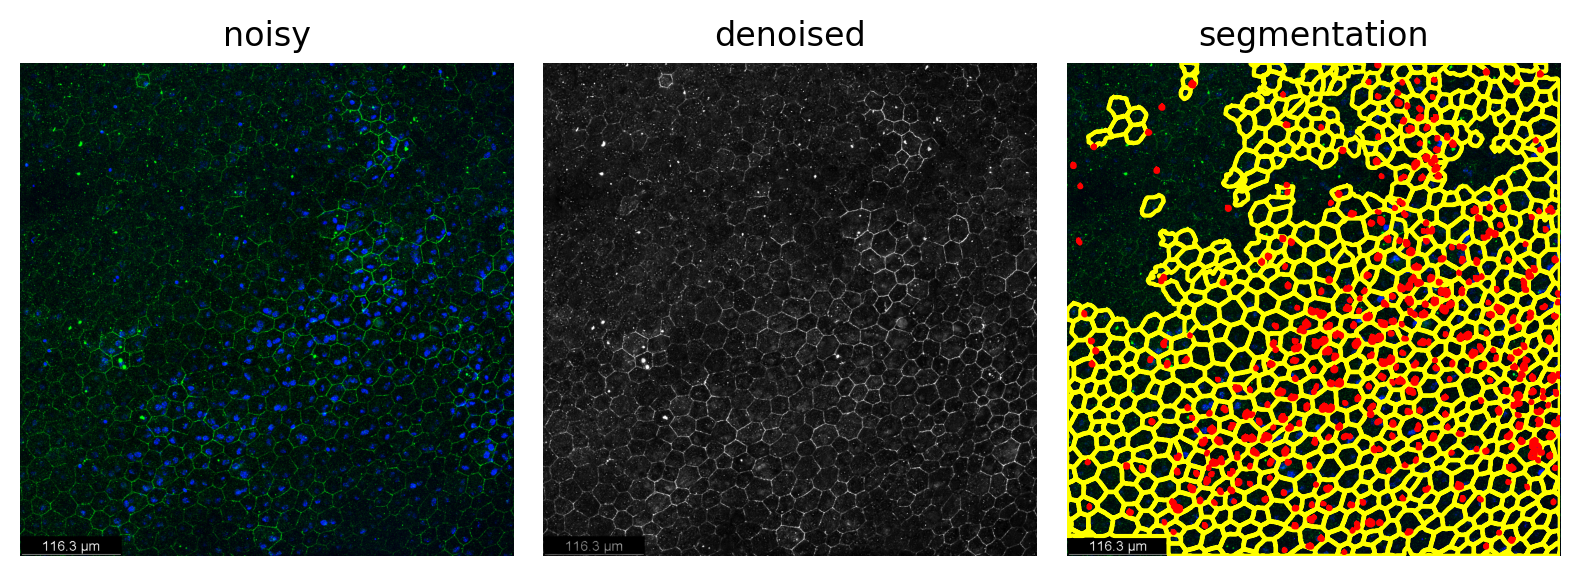

In [30]:
plt.figure(figsize=(8, 4))

img = images[0].squeeze()
plt.subplot(1,3,1)
plt.imshow(img, cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("noisy")

img_dn = cell_imgs_dn[0].squeeze()
plt.subplot(1,3,2)
plt.imshow(img_dn[...,0], cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("denoised")

plt.subplot(1,3,3)
plt.imshow(img, cmap="gray", vmin=0, vmax=1)

# max_outlines = [cell_outlines[i[0]] for i in max_indices]

single_cell = cell_outlines[12]

for o in cell_outlines:
    plt.plot(o[:,0], o[:,1], color=[1,1,0])
    plt.axis('off')
    plt.title("segmentation")


for nucleus_outline in nuclei_outlines:
    # if nucleus_inside_cell(single_cell.astype(np.float32), nucleus_outline):
    plt.plot(nucleus_outline[:,0], nucleus_outline[:,1], color='r')
    plt.axis('off')
    plt.title("segmentation")


plt.tight_layout()
plt.show()

In [ ]:
def nuclei_per_cell_mask(cell_mask, nuclei_mask):
    cell_dict = {}
    for i, cell_row in enumerate(cell_mask):
        for j, cell in enumerate(cell_row):

            if cell != 0 and nuclei_mask[i][j] != 0:
                if cell not in cell_dict:
                    cell_dict[cell] = {nuclei_mask[i][j]}
                else:
                    cell_dict[cell].add(nuclei_mask[i][j])
    return {k:len(v) for k, v in cell_dict.items() if len(v)>2}



In [ ]:
def cell_areas(cell_mask):
    unique, counts = np.unique(cell_mask, return_counts=True)
    cell_area_dict = dict(zip(unique, counts))
    cell_area_dict.pop(0)
    return cell_area_dict

def cell_diameters(cell_mask):
    areas = cell_areas(cell_mask)
    return {cell_id: 2 * np.sqrt(area / np.pi) for cell_id, area in areas.items()}    
print(cell_areas(cell_masks[0]))
print(cell_diameters(cell_masks[0]))
    

{1: 706, 2: 88, 3: 796, 4: 587, 5: 240, 6: 619, 7: 509, 8: 607, 9: 950, 10: 1171, 11: 920, 12: 1210, 13: 108, 14: 913, 15: 388, 16: 909, 17: 1354, 18: 974, 19: 1145, 20: 1079, 21: 1266, 22: 1723, 23: 762, 24: 795, 25: 615, 26: 645, 27: 1431, 28: 723, 29: 1745, 30: 1163, 31: 961, 32: 784, 33: 1134, 34: 1250, 35: 1566, 36: 708, 37: 1679, 38: 1537, 39: 400, 40: 989, 41: 911, 42: 1064, 43: 770, 44: 791, 45: 1179, 46: 527, 47: 2132, 48: 862, 49: 1260, 50: 825, 51: 1379, 52: 1144, 53: 1463, 54: 895, 55: 1075, 56: 639, 57: 702, 58: 1029, 59: 1109, 60: 1027, 61: 1479, 62: 1013, 63: 917, 64: 916, 65: 1585, 66: 1314, 67: 1126, 68: 702, 69: 1242, 70: 659, 71: 1335, 72: 919, 73: 911, 74: 837, 75: 2031, 76: 1310, 77: 925, 78: 1142, 79: 904, 80: 854, 81: 808, 82: 1505, 83: 1042, 84: 1724, 85: 1672, 86: 968, 87: 1286, 88: 697, 89: 1074, 90: 955, 91: 1505, 92: 938, 93: 1064, 94: 1049, 95: 596, 96: 624, 97: 1771, 98: 1549, 99: 683, 100: 875, 101: 740, 102: 880, 103: 1335, 104: 663, 105: 1244, 106: 1117

TypeError: unsupported operand type(s) for /: 'dict_values' and 'int'

In [32]:
filtered_cell_counts = nuclei_per_cell_mask(cell_masks[0], nuclei_masks[0])

In [33]:
new_cell_mask = [[cell if cell in filtered_cell_counts else 0 for cell in row ] for row in cell_masks[0]]

In [ ]:
cell_masks, cell_flows, cell_styles, cell_imgs_dn

In [ ]:
io.masks_flows_to_seg(images, np.array(new_cell_mask), cell_flows[0], files[0], channels=channels)